In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


## Title:
Diabetes Prediction Challenge

## Description:
Predict the likelihood of diabetes in individuals using clinical, lifestyle, and demographic data. The dataset includes features such as age, BMI, blood pressure, cholesterol levels, physical activity, sleep patterns, diet score, family history, and other health indicators. Participants are tasked with building a robust machine learning model that can accurately classify whether a person is likely to be diagnosed with diabetes.

The goal of this challenge is to leverage data-driven insights for early detection and risk assessment, enabling preventive healthcare strategies. Models will be evaluated based on predictive accuracy, with special attention to handling imbalanced data and ensuring interpretability of results.

In [2]:
# Modern visualization theme
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#161b22'
plt.rcParams['axes.edgecolor'] = '#30363d'
plt.rcParams['grid.color'] = '#21262d'
plt.rcParams['text.color'] = '#c9d1d9'
plt.rcParams['axes.labelcolor'] = '#c9d1d9'
plt.rcParams['xtick.color'] = '#8b949e'
plt.rcParams['ytick.color'] = '#8b949e'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'

# Custom gradient palette
violet_gradient = ['#7b2cbf', '#9d4edd', '#c77dff', '#e0aaff', '#f72585', '#ff006e']
sns.set_palette(violet_gradient)

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv")

# Identify target variable
target_col = train_df.columns.tolist()[-1]

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
train_df.head()

Training data shape: (700000, 26)
Test data shape: (300000, 25)


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [4]:
sample_submission_data = pd.read_csv(r"/kaggle/input/playground-series-s5e12/sample_submission.csv")

## Exploratory data analysis

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

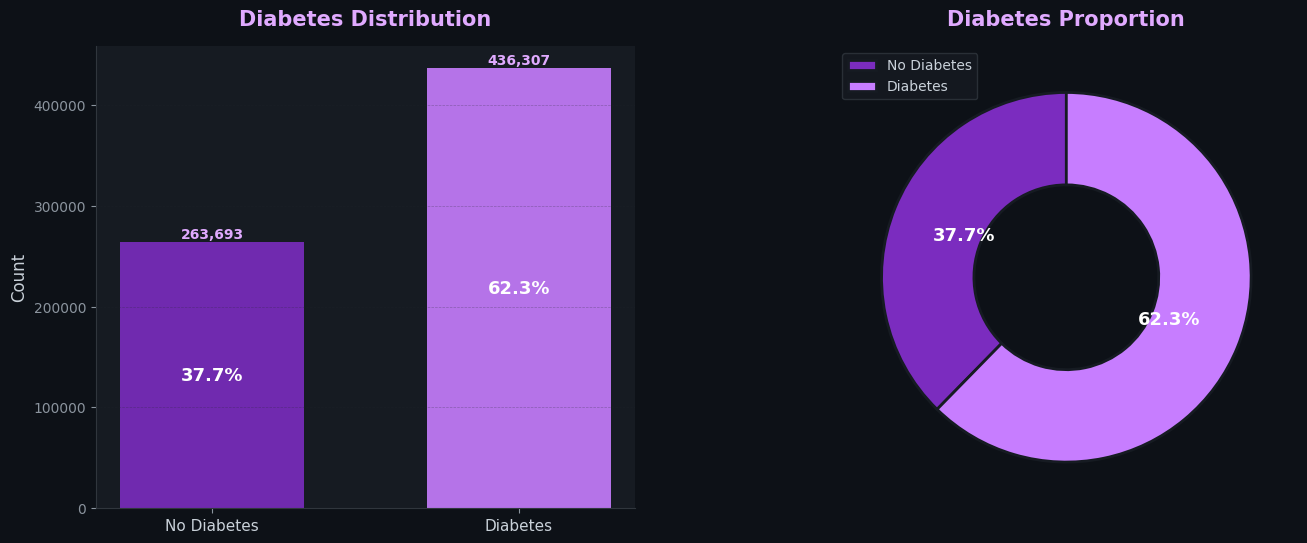


Class Distribution:
Diabetes: 436,307 (62.33%)
No Diabetes: 263,693 (37.67%)


In [6]:
target_col = "diagnosed_diabetes"

# Calculate class distribution
target_counts = train_df[target_col].value_counts().sort_index()
total = len(train_df)
fig = plt.figure(figsize=(16, 6), facecolor='#0d1117')
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])

x_pos = np.arange(len(target_counts))
bars = ax1.bar(
    x_pos,
    target_counts.values,
    width=0.6,
    color=['#7b2cbf', '#c77dff'],
    edgecolor='none',
    alpha=0.9
)

# Styling
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['No Diabetes', 'Diabetes'], fontsize=11, color='#c9d1d9')
ax1.set_ylabel('Count', fontsize=12, color='#c9d1d9')
ax1.set_title('Diabetes Distribution', fontsize=15, color='#e0aaff', pad=15, weight='600')

# Remove extra spines
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)
ax1.spines["left"].set_color('#30363d')
ax1.spines["bottom"].set_color('#30363d')

ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# Value labels
for bar, count in zip(bars, target_counts.values):
    height = bar.get_height()

    # Top label
    ax1.text(
        bar.get_x() + bar.get_width()/2., height + total*0.005,
        f'{count:,}', ha='center', color='#e0aaff', fontsize=10, weight='600'
    )

    # Middle % label
    ax1.text(
        bar.get_x() + bar.get_width()/2., height/2,
        f'{count/total*100:.1f}%',
        ha='center', va='center', color='#ffffff', fontsize=13, weight='700'
    )
ax2 = fig.add_subplot(gs[0, 1])

colors = ['#7b2cbf', '#c77dff']

wedges, texts, autotexts = ax2.pie(
    target_counts.values,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.5, edgecolor='#161b22', linewidth=2)
)

for autotext in autotexts:
    autotext.set_color('#ffffff')
    autotext.set_fontsize(13)
    autotext.set_weight('700')

ax2.set_title(
    'Diabetes Proportion',
    fontsize=15,
    color='#e0aaff',
    pad=15,
    weight='600'
)

ax2.legend(
    ['No Diabetes', 'Diabetes'],
    loc='upper left',
    frameon=True,
    facecolor='#161b22',
    edgecolor='#30363d',
    fontsize=10,
    labelcolor='#c9d1d9'
)

plt.tight_layout()
plt.show()
print("\nClass Distribution:")
print(f"Diabetes: {target_counts[1]:,} ({target_counts[1]/total*100:.2f}%)")
print(f"No Diabetes: {target_counts[0]:,} ({target_counts[0]/total*100:.2f}%)")


## Numarical feature distribution

In [7]:
train_df.isnull().sum().sort_values(ascending=False)

id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0


In [8]:
test_df.isnull().sum().sort_values(ascending=False)

id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0


In [9]:
train_df = train_df.dropna()
train_df = train_df.drop_duplicates()

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [11]:
train_df.columns

Index(['id', 'age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'gender', 'ethnicity', 'education_level',
       'income_level', 'smoking_status', 'employment_status',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'diagnosed_diabetes'],
      dtype='object')

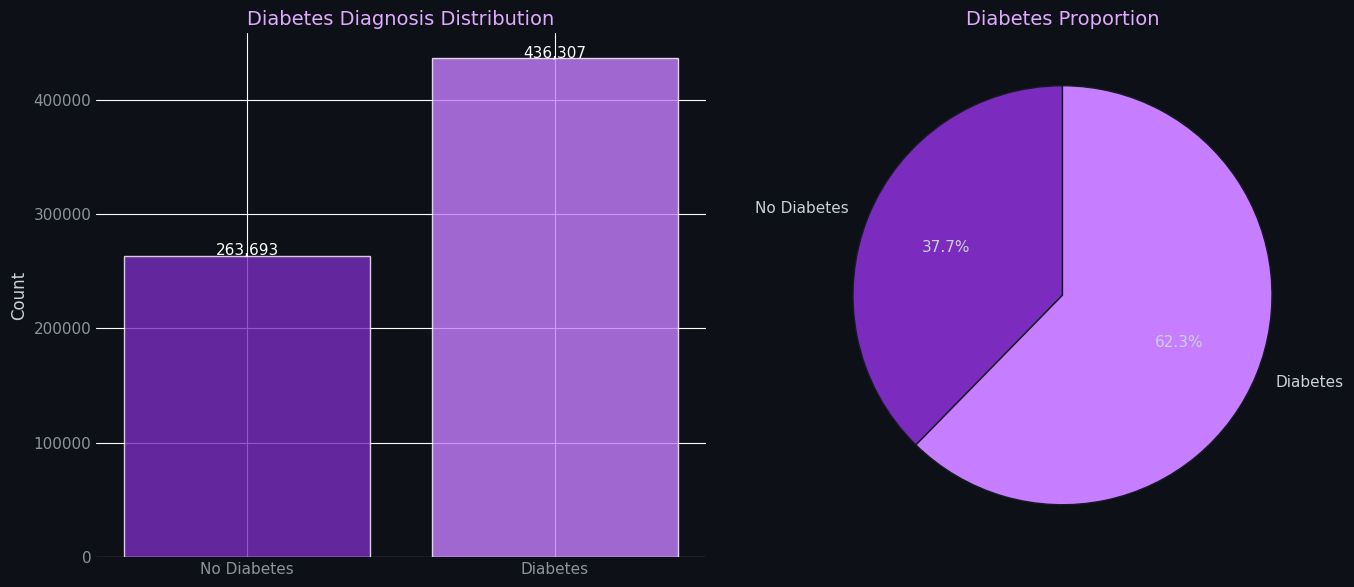

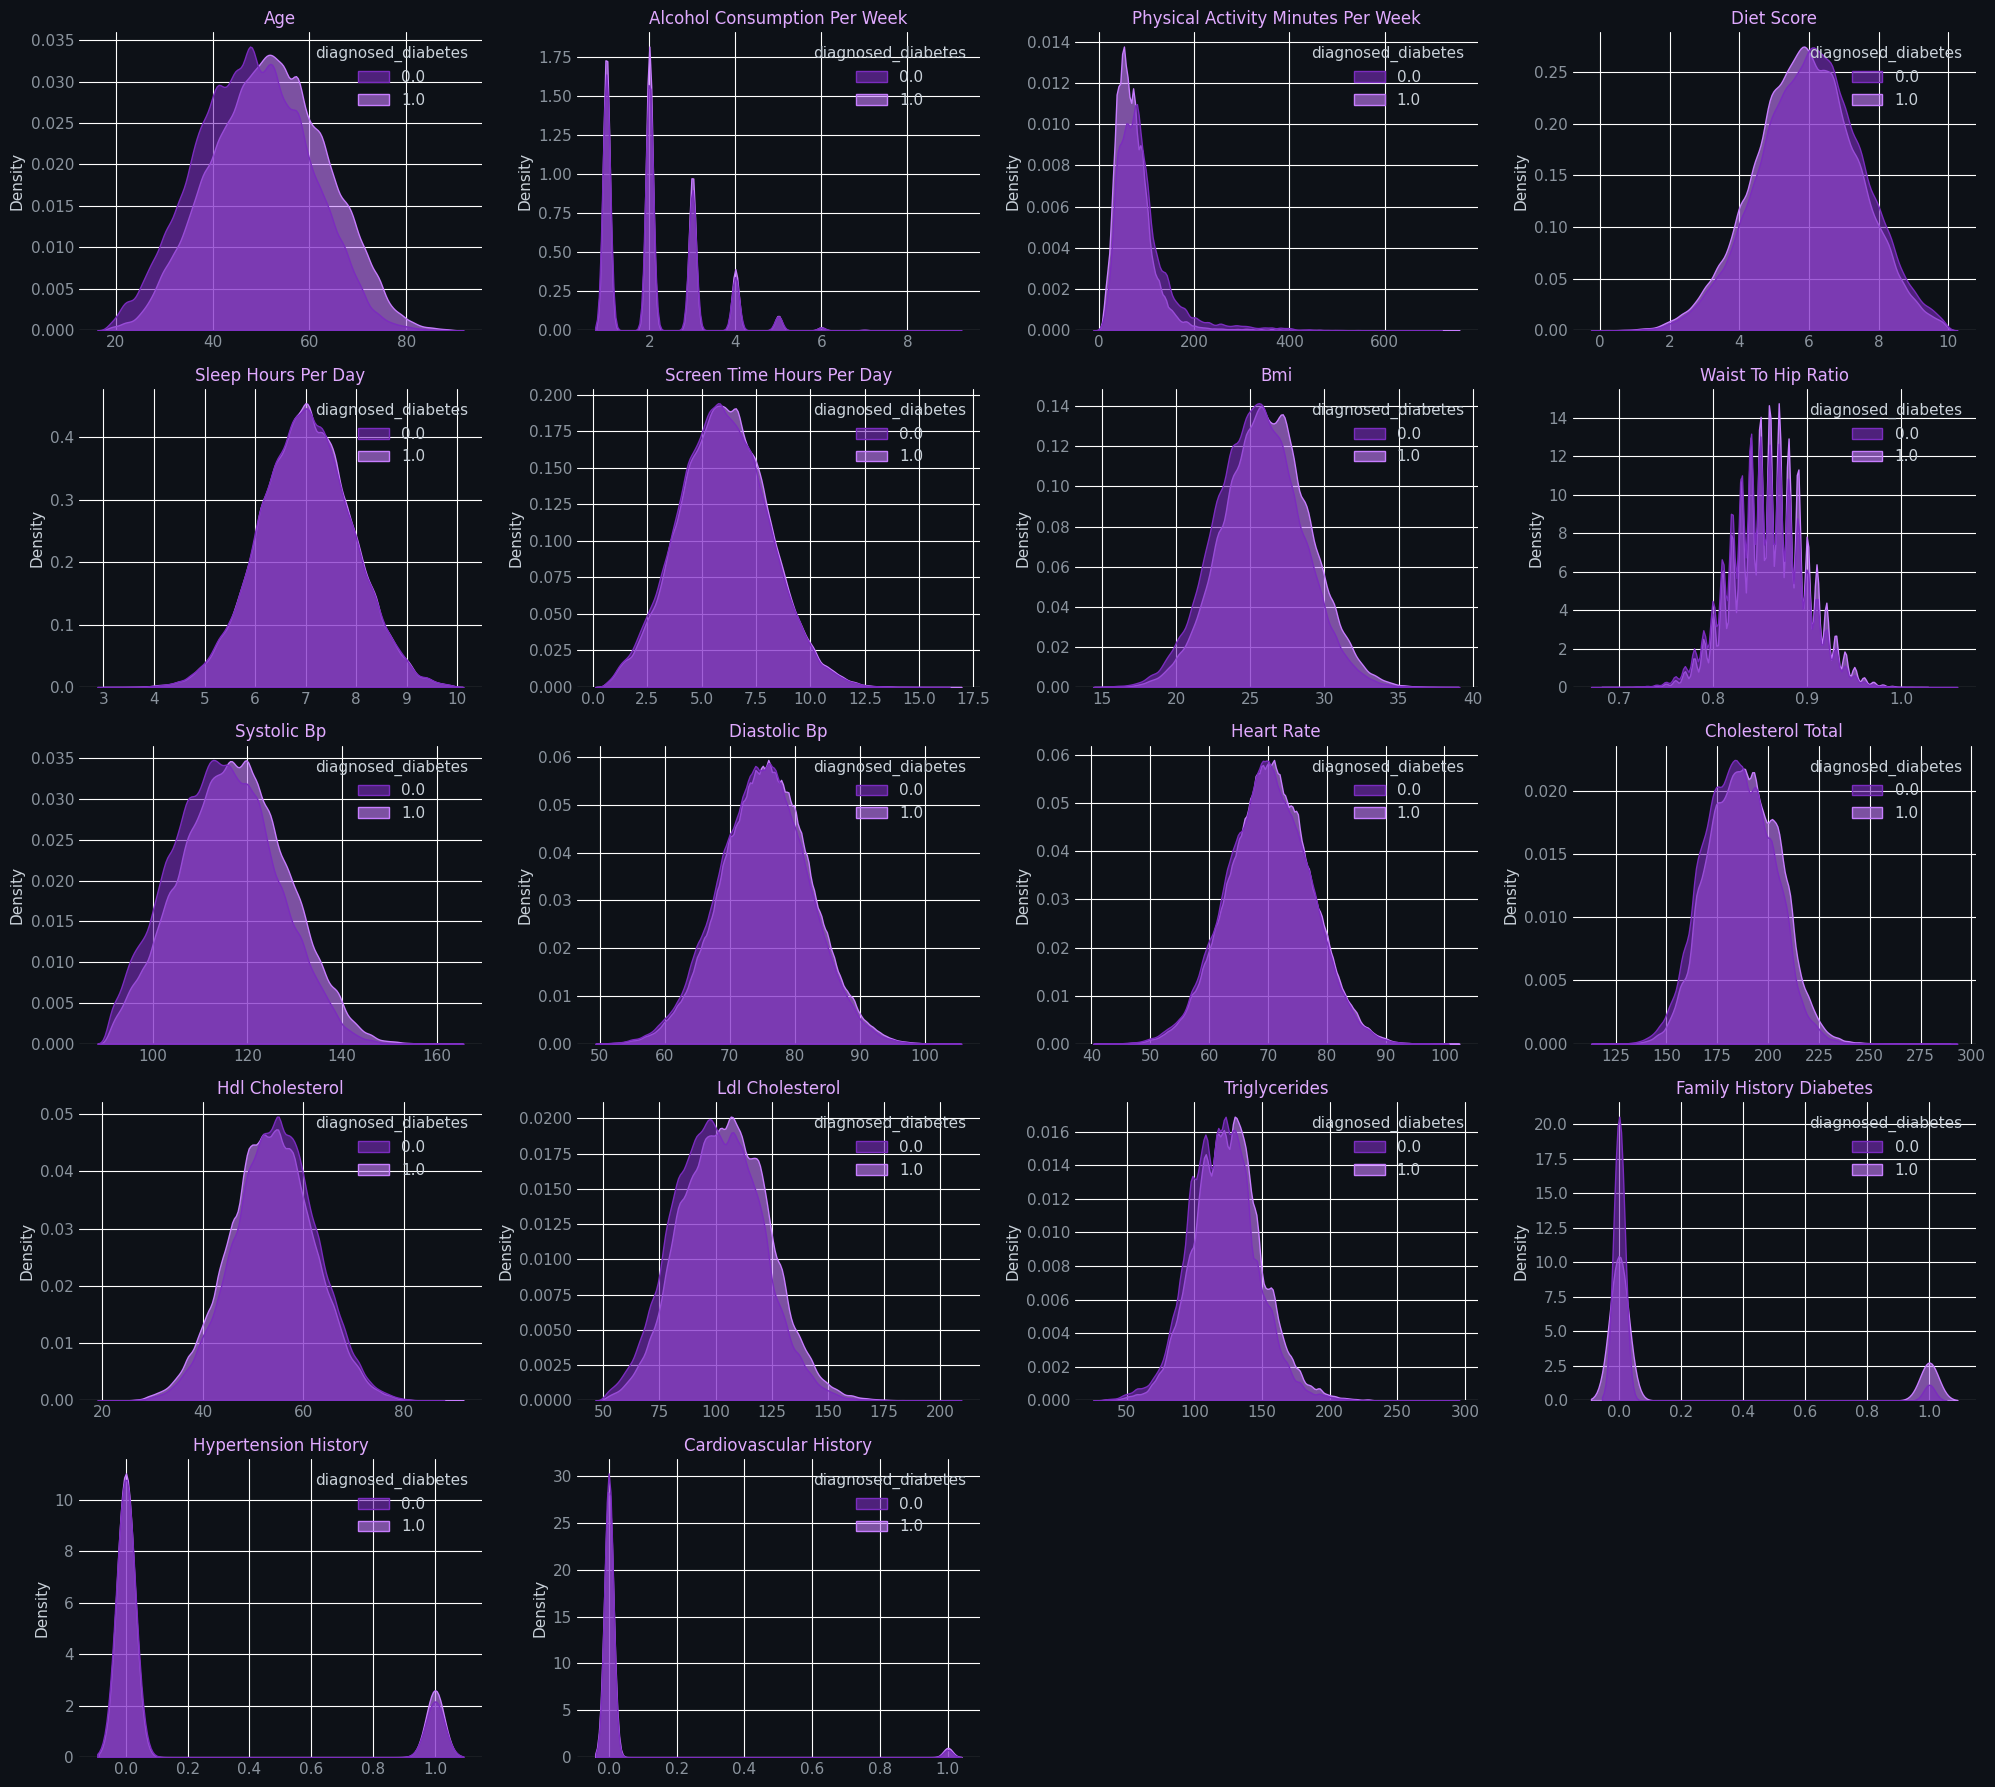

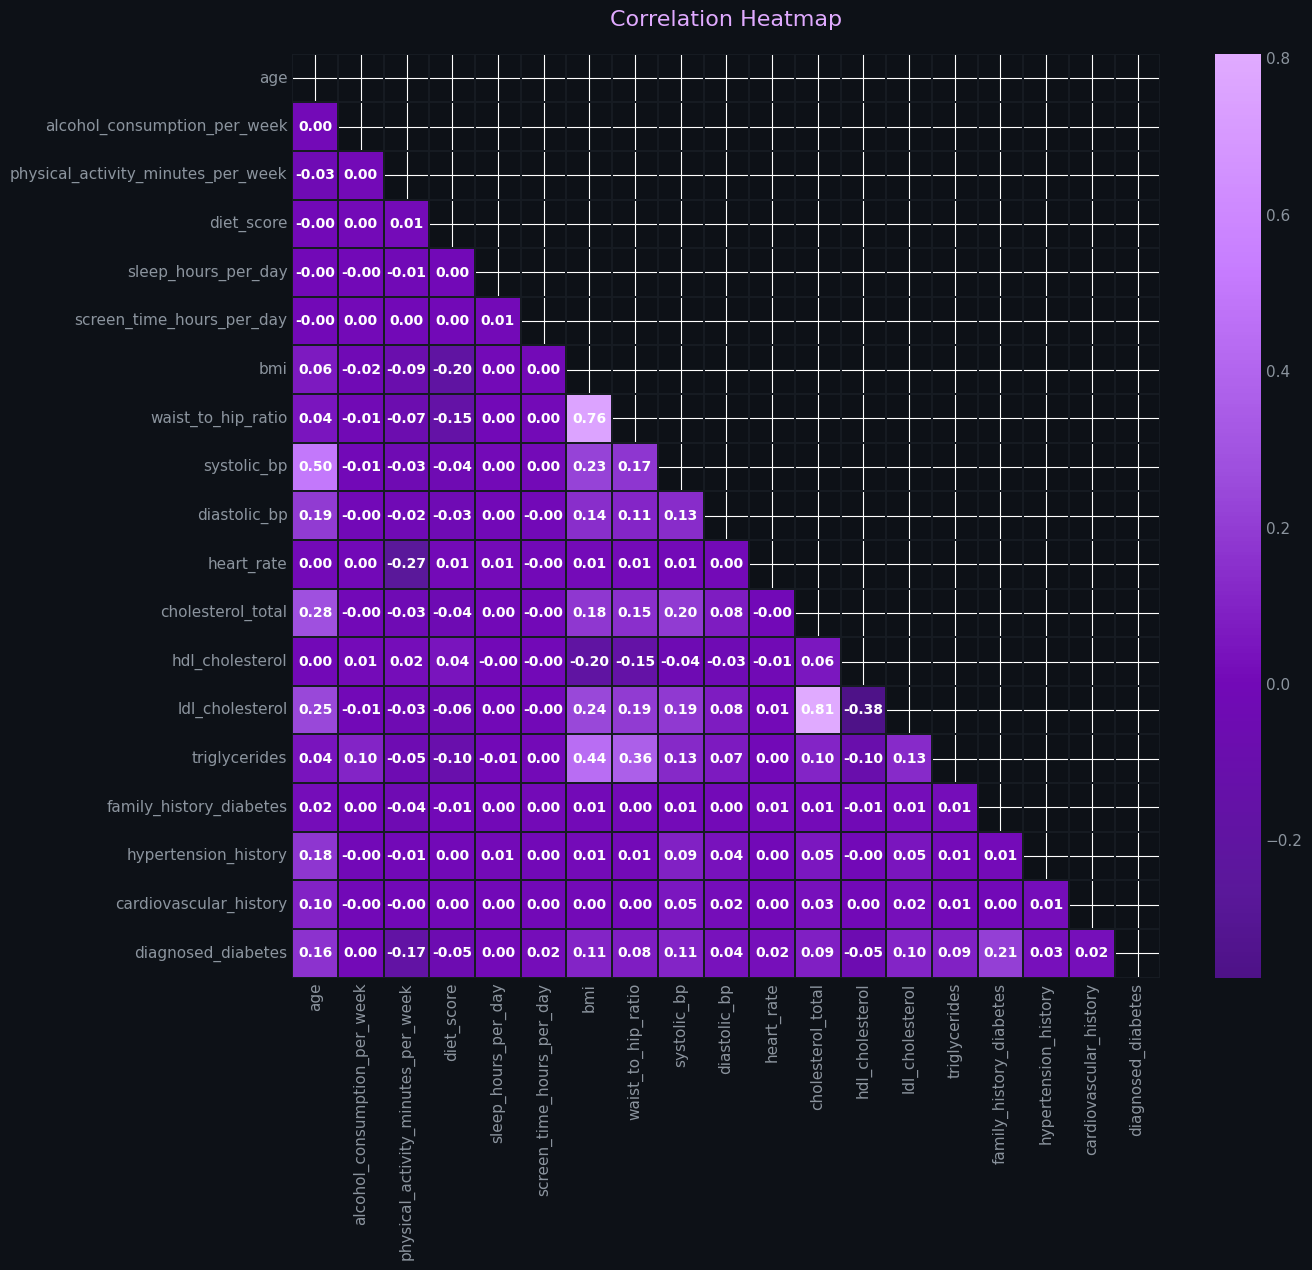

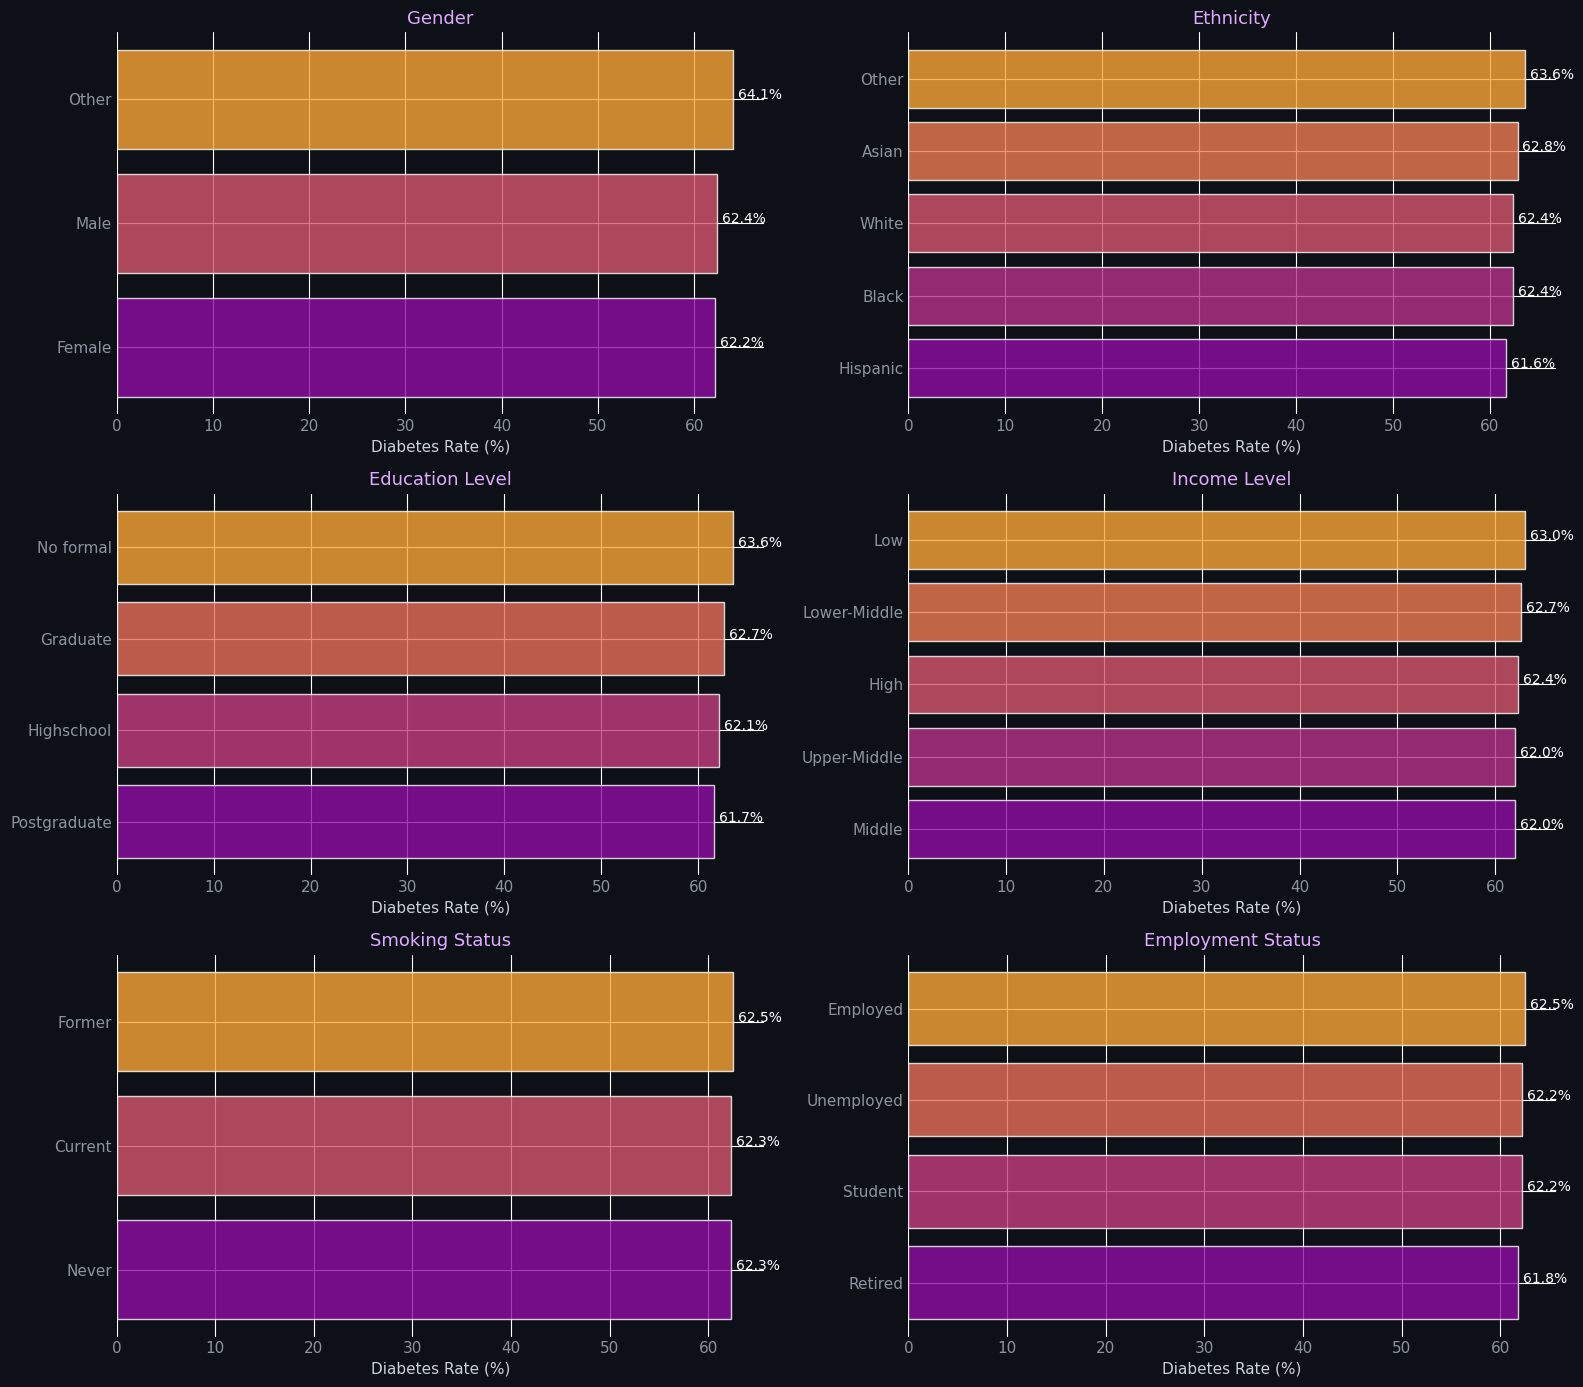

In [12]:
from matplotlib.colors import LinearSegmentedColormap

# Set global style
plt.style.use('seaborn-darkgrid')
sns.set_style("darkgrid")
plt.rcParams.update({
    "figure.facecolor": "#0d1117",
    "axes.facecolor": "#0d1117",
    "axes.edgecolor": "#30363d",
    "axes.labelcolor": "#c9d1d9",
    "xtick.color": "#8b949e",
    "ytick.color": "#8b949e",
    "text.color": "#c9d1d9",
    "font.size": 11
})
target_col = 'diagnosed_diabetes'
numeric_features = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day',
    'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
    'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history'
]
categorical_features = [
    'gender', 'ethnicity', 'education_level', 'income_level',
    'smoking_status', 'employment_status'
]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
target_counts = train_df[target_col].value_counts().sort_index()

# Bar plot
axes[0].bar(['No Diabetes', 'Diabetes'], target_counts.values, color=['#7b2cbf', '#c77dff'], alpha=0.8)
axes[0].set_title("Diabetes Diagnosis Distribution", fontsize=14, color='#e0aaff')
axes[0].set_ylabel("Count", fontsize=12)
for i, val in enumerate(target_counts.values):
    axes[0].text(i, val + 500, f'{val:,}', ha='center', color='white', fontsize=11)

# Pie chart
axes[1].pie(target_counts.values, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%',
            startangle=90, colors=['#7b2cbf', '#c77dff'], wedgeprops=dict(edgecolor='#161b22'))
axes[1].set_title("Diabetes Proportion", fontsize=14, color='#e0aaff')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(5, 4, figsize=(20, 18))
axes = axes.flatten()

for idx, col in enumerate(numeric_features):
    ax = axes[idx]
    sns.kdeplot(data=train_df, x=col, hue=target_col, fill=True, common_norm=False,
                palette=['#7b2cbf', '#c77dff'], alpha=0.6, ax=ax)
    ax.set_title(col.replace("_", " ").title(), fontsize=12, color='#e0aaff')
    ax.set_xlabel('')
    ax.set_ylabel('Density')

for ax in axes[len(numeric_features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
corr = train_df[numeric_features + [target_col]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = LinearSegmentedColormap.from_list('modern_violet', 
                                         ['#240046', '#3c096c', '#5a189a', '#7209b7', '#9d4edd', '#c77dff', '#e0aaff'])

plt.figure(figsize=(14, 12))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=cmap, center=0, linewidths=1.2, linecolor='#161b22', annot_kws={"size":10, "weight":"bold", "color":"white"})
plt.title("Correlation Heatmap", fontsize=16, color='#e0aaff', pad=20)
plt.show()
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, col in enumerate(categorical_features):
    ax = axes[idx]
    ct = train_df.groupby(col)[target_col].mean().sort_values()
    colors = plt.cm.plasma(np.linspace(0.3, 0.8, len(ct)))
    ax.barh(ct.index, ct.values * 100, color=colors, alpha=0.8)
    ax.set_xlabel('Diabetes Rate (%)', fontsize=11)
    ax.set_title(col.replace("_", " ").title(), fontsize=13, color='#e0aaff')
    for i, val in enumerate(ct.values * 100):
        ax.text(val + 0.5, i, f"{val:.1f}%", color='white', fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
train_df.describe()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,349999.500000,50.359734,2.072411,80.230803,5.963695,7.002200,6.012733,25.874684,0.858766,116.294193,75.440924,70.167749,186.818801,53.823214,102.905854,123.081850,0.149401,0.181990,0.030324,0.623296
std,202072.738554,11.655520,1.048189,51.195071,1.463336,0.901907,2.022707,2.860705,0.037980,11.010390,6.825775,6.938722,16.730832,8.266545,19.022416,24.739397,0.356484,0.385837,0.171478,0.484560
min,0.000000,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.680000,91.000000,51.000000,42.000000,117.000000,21.000000,51.000000,31.000000,0.000000,0.000000,0.000000,0.000000
25%,174999.750000,42.000000,1.000000,49.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,175.000000,48.000000,89.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,349999.500000,50.000000,2.000000,71.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000,1.000000
75%,524999.250000,58.000000,3.000000,96.000000,7.000000,7.600000,7.400000,27.800000,0.880000,124.000000,80.000000,75.000000,199.000000,59.000000,116.000000,139.000000,0.000000,0.000000,0.000000,1.000000
max,699999.000000,89.000000,9.000000,747.000000,9.900000,9.900000,16.500000,38.400000,1.050000,163.000000,104.000000,101.000000,289.000000,90.000000,205.000000,290.000000,1.000000,1.000000,1.000000,1.000000


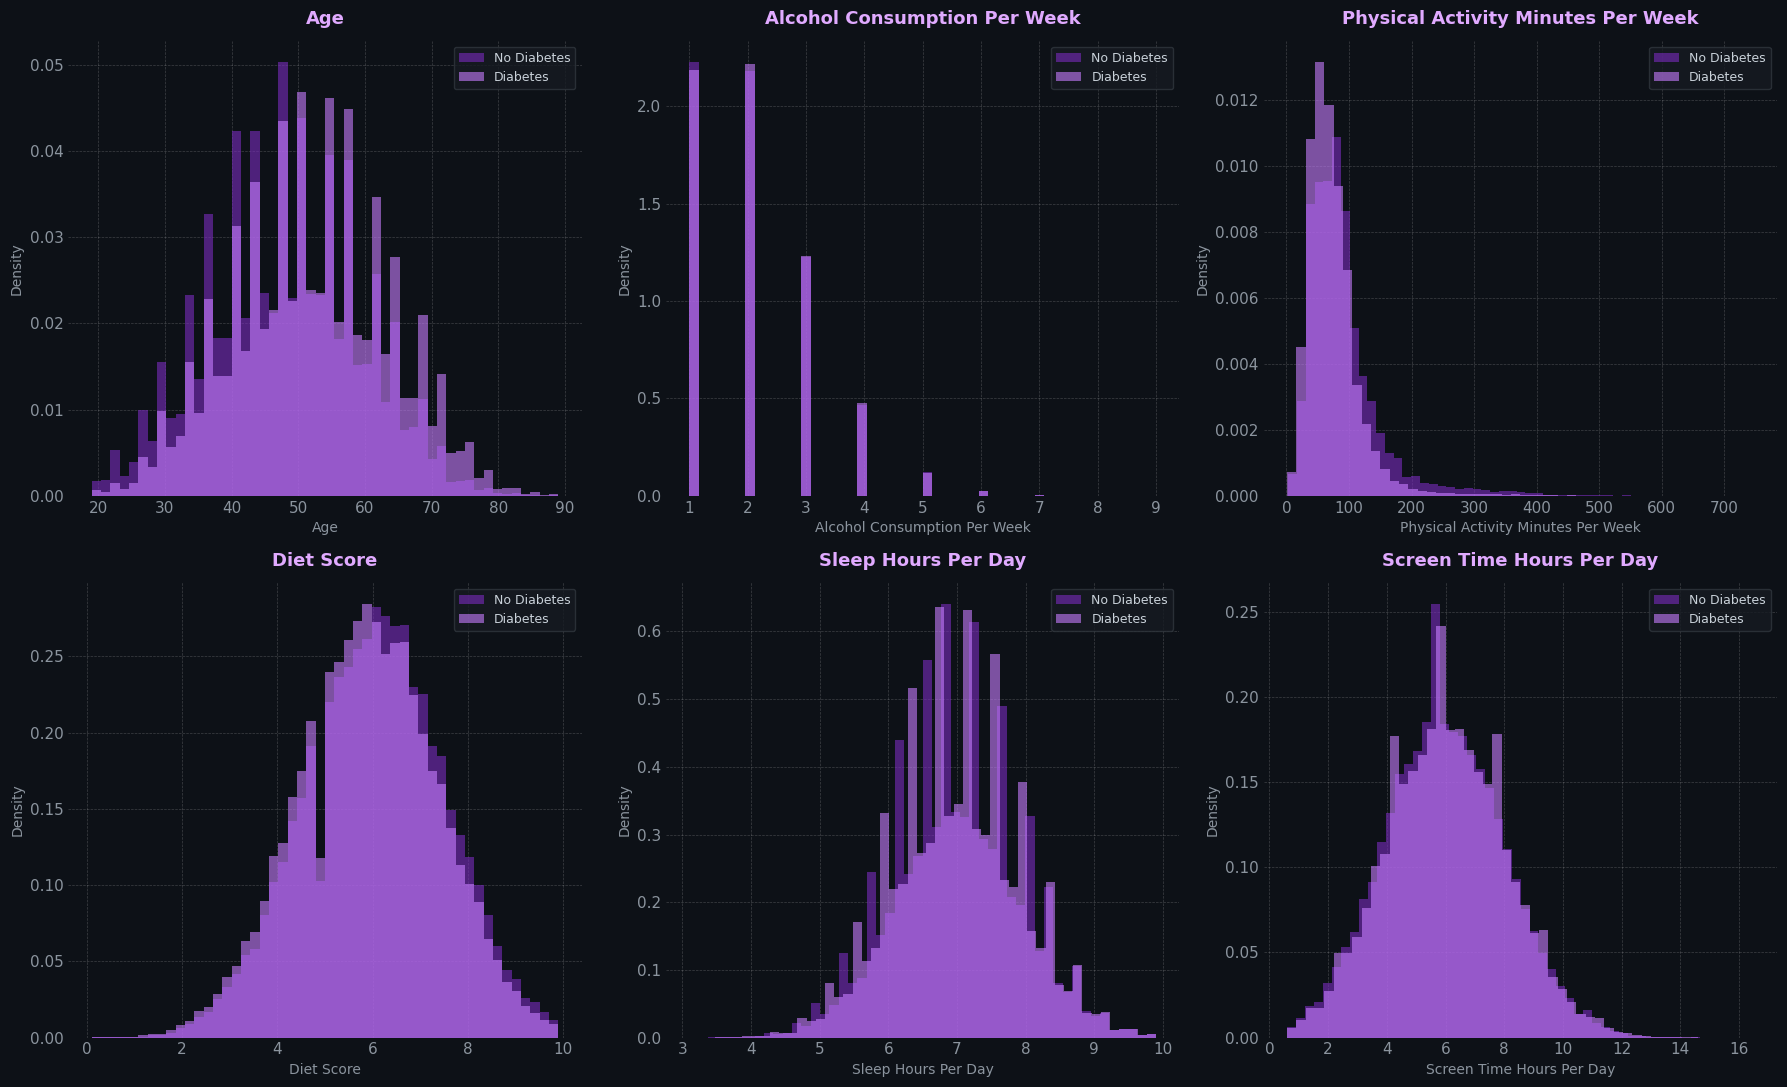

In [14]:
numerical_cols = [
    'age',
    'alcohol_consumption_per_week',
    'physical_activity_minutes_per_week',
    'diet_score',
    'sleep_hours_per_day',
    'screen_time_hours_per_day'
]

target_col = "diagnosed_diabetes"

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 11), facecolor='#0d1117')
fig.subplots_adjust(hspace=0.35, wspace=0.3)
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]

    # Separate data based on diabetes
    data_0 = train_df[train_df[target_col] == 0][col].dropna()
    data_1 = train_df[train_df[target_col] == 1][col].dropna()

    # Histograms
    ax.hist(data_0, bins=50, alpha=0.6, color='#7b2cbf',
            edgecolor='none', label='No Diabetes', density=True)
    ax.hist(data_1, bins=50, alpha=0.6, color='#c77dff',
            edgecolor='none', label='Diabetes', density=True)

    # Titles + labels
    title = col.replace("_", " ").title()
    ax.set_title(title, fontsize=13, color='#e0aaff', pad=12, weight='600')
    ax.set_xlabel(title, fontsize=10, color='#8b949e')
    ax.set_ylabel('Density', fontsize=10, color='#8b949e')

    # Legend styling
    ax.legend(
        loc='upper right',
        frameon=True,
        facecolor='#161b22',
        edgecolor='#30363d',
        fontsize=9,
        labelcolor='#c9d1d9'
    )

    # Axes styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#30363d')
    ax.spines['bottom'].set_color('#30363d')

    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

# Turn off last empty subplot if <6 columns
if len(numerical_cols) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()


## Co-relation with heatmap

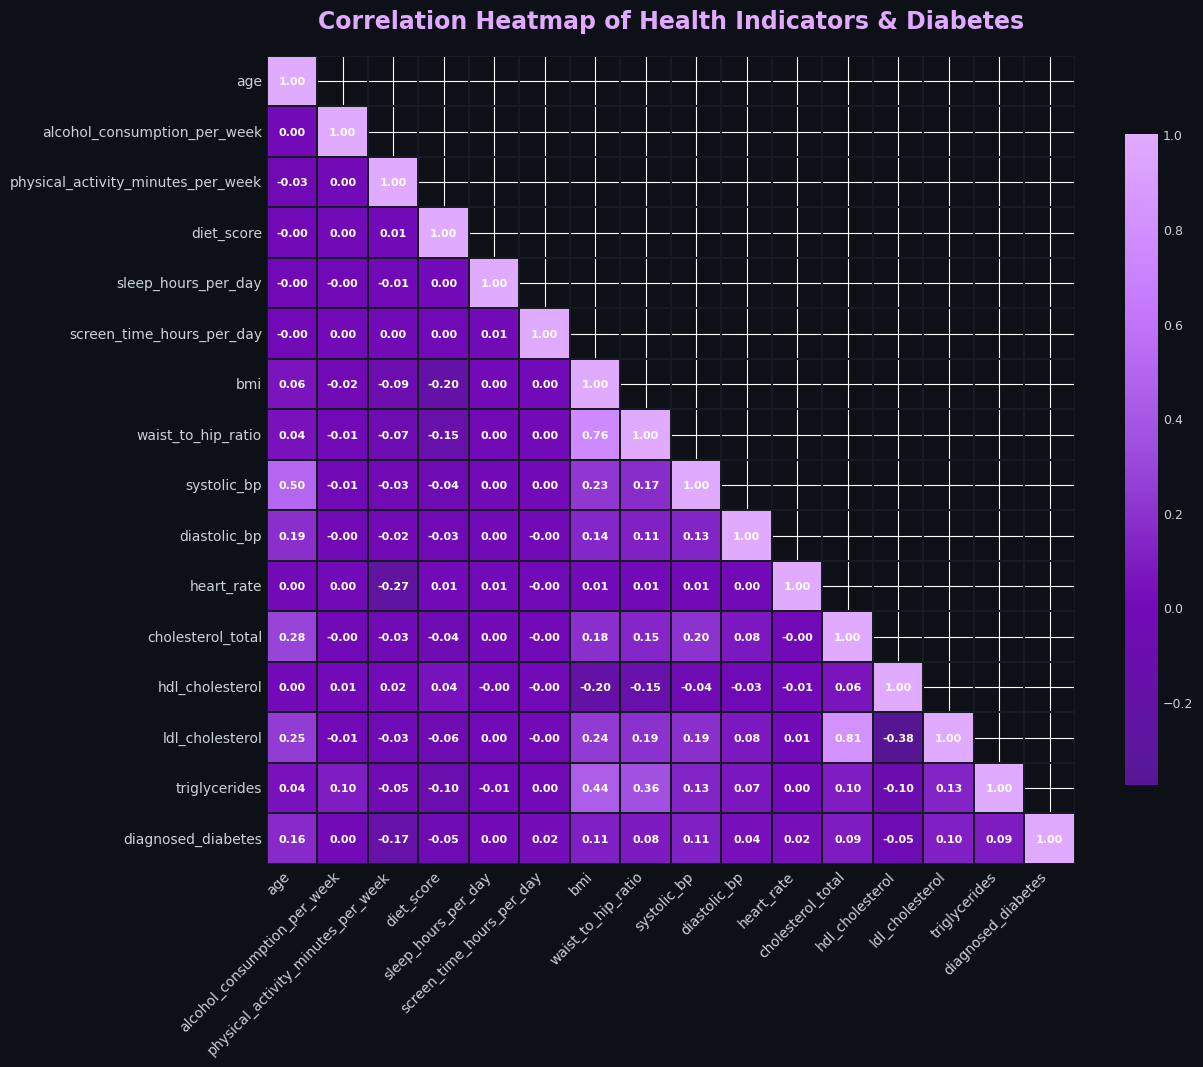

In [15]:
from matplotlib.colors import LinearSegmentedColormap

# Numerical columns in your dataset
numerical_cols = [
    'age',
    'alcohol_consumption_per_week',
    'physical_activity_minutes_per_week',
    'diet_score',
    'sleep_hours_per_day',
    'screen_time_hours_per_day',
    'bmi',
    'waist_to_hip_ratio',
    'systolic_bp',
    'diastolic_bp',
    'heart_rate',
    'cholesterol_total',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'triglycerides'
]

target_col = 'diagnosed_diabetes'

numeric_data = train_df[numerical_cols + [target_col]]
correlation_matrix = numeric_data.corr()

fig, ax = plt.subplots(figsize=(13, 11), facecolor='#0d1117')

# Modern violet gradient
cmap = LinearSegmentedColormap.from_list(
    'modern_violet',
    ['#240046', '#3c096c', '#5a189a', '#7209b7', '#9d4edd', '#c77dff', '#e0aaff']
)

# Mask upper triangular for cleaner look
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    center=0,
    square=True,
    linewidths=1.3,
    linecolor='#161b22',
    cbar_kws={'shrink': 0.75},
    ax=ax,
    annot_kws={'size': 8, 'weight': '600', 'color': '#ffffff'}
)

ax.set_title(
    'Correlation Heatmap of Health Indicators & Diabetes',
    fontsize=17,
    color='#e0aaff',
    pad=20,
    weight='600'
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, color='#c9d1d9')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10, color='#c9d1d9')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=9, colors='#c9d1d9')
cbar.outline.set_edgecolor('#30363d')

plt.tight_layout()
plt.show()

## Categorical features analysis

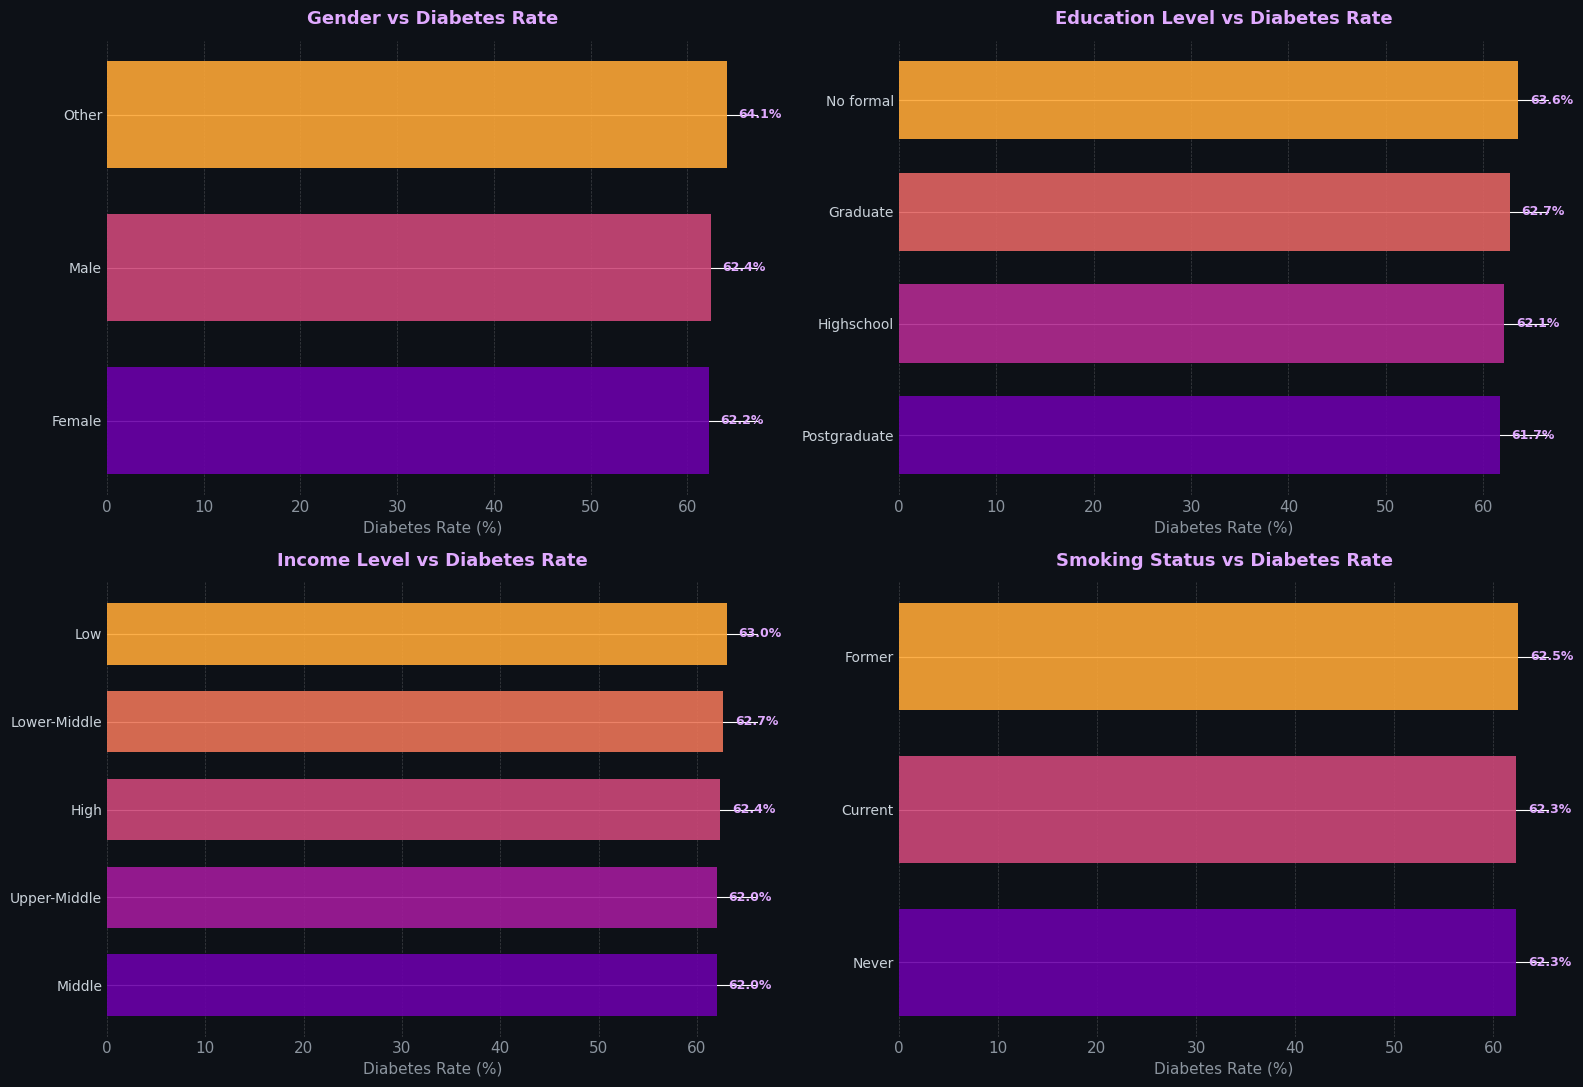

In [16]:
categorical_cols = [
    'gender',
    'education_level',
    'income_level',
    'smoking_status'
]

target_col = 'diagnosed_diabetes'

fig, axes = plt.subplots(2, 2, figsize=(16, 11), facecolor='#0d1117')
fig.subplots_adjust(hspace=0.35, wspace=0.3)
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    
    # Compute diabetes rate and count
    diabetes_rate = train_df.groupby(col)[target_col].agg(['mean', 'count'])
    diabetes_rate = diabetes_rate.sort_values('mean', ascending=True)
    
    # Colors
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(diabetes_rate)))
    
    y_pos = np.arange(len(diabetes_rate))
    bars = ax.barh(
        y_pos,
        diabetes_rate['mean'] * 100,
        height=0.7,
        color=colors,
        edgecolor='none',
        alpha=0.9
    )
    
    # Labels & title
    ax.set_yticks(y_pos)
    ax.set_yticklabels(diabetes_rate.index, fontsize=10, color='#c9d1d9')
    ax.set_xlabel('Diabetes Rate (%)', fontsize=11, color='#8b949e')
    ax.set_title(
        f'{col.replace("_", " ").title()} vs Diabetes Rate',
        fontsize=13,
        color='#e0aaff',
        pad=12,
        weight='600'
    )
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#30363d')
    ax.spines['bottom'].set_color('#30363d')
    ax.grid(True, alpha=0.2, axis='x', linestyle='--', linewidth=0.5)
    
    # Annotate percentages
    for i, (bar, val) in enumerate(zip(bars, diabetes_rate['mean'] * 100)):
        ax.text(
            val + 1.2,
            i,
            f'{val:.1f}%',
            va='center',
            color='#e0aaff',
            fontsize=9,
            weight='600'
        )

plt.tight_layout()
plt.show()

## Data preprocessing

In [17]:
# ----- Feature Engineering Using Provided Columns -----

# 1. Round numerical features (example: bmi, sleep_hours, alcohol consumption)
for column in [
    'bmi', 'sleep_hours_per_day', 'alcohol_consumption_per_week'
]:
    for suffix, decimals in {'1s': 0, '10s': -1}.items():
        train_df[f'{column}_ROUND_{suffix}'] = train_df[column].round(decimals)
        test_df[f'{column}_ROUND_{suffix}'] = test_df[column].round(decimals)

# 2. Calculate blood pressure ratio & pulse pressure
for dataset in [train_df, test_df]:
    dataset['bp_ratio'] = dataset['systolic_bp'] / (dataset['diastolic_bp'] + 1)
    dataset['pulse_pressure'] = dataset['systolic_bp'] - dataset['diastolic_bp']

# 3. Cholesterol-derived features
for dataset in [train_df, test_df]:
    dataset['cholesterol_ratio'] = dataset['cholesterol_total'] / (dataset['hdl_cholesterol'] + 1)
    dataset['ldl_hdl_ratio'] = dataset['ldl_cholesterol'] / (dataset['hdl_cholesterol'] + 1)
    dataset['non_hdl_cholesterol'] = dataset['cholesterol_total'] - dataset['hdl_cholesterol']

# 4. Lifestyle composite score (higher = worse lifestyle)
for dataset in [train_df, test_df]:
    dataset['lifestyle_risk_score'] = (
        dataset['alcohol_consumption_per_week']*0.2 +
        dataset['screen_time_hours_per_day']*0.3 -
        dataset['physical_activity_minutes_per_week']*0.1 +
        dataset['sleep_hours_per_day']*0.1 +
        dataset['diet_score']*0.2
    )

# 5. Obesity indicator
for dataset in [train_df, test_df]:
    dataset['is_obese'] = (dataset['bmi'] >= 30).astype(int)

print("Feature engineering completed for provided columns!")


Feature engineering completed for provided columns!


## Identify feature types

In [18]:
# Identify feature types BEFORE applying encoding

# Remove ID + Target column
feature_cols = train_df.drop(columns=[target_col, "id"]).columns.tolist()

# Categorical columns → object or category dtype
categorical_features = [
    col for col in feature_cols 
    if train_df[col].dtype in ["object", "category"]
]

# Numeric columns → exclude object, category, and bool
numeric_features = [
    col for col in feature_cols 
    if train_df[col].dtype not in ["object", "category", "bool"]
]

print(f"Total features: {len(feature_cols)}")
print(f"Categorical features: {len(categorical_features)}")
print("Categorical:", categorical_features)
print(f"Numeric features: {len(numeric_features)}")
print("Numeric:", numeric_features)


Total features: 37
Categorical features: 6
Categorical: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
Numeric features: 31
Numeric: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi_ROUND_1s', 'bmi_ROUND_10s', 'sleep_hours_per_day_ROUND_1s', 'sleep_hours_per_day_ROUND_10s', 'alcohol_consumption_per_week_ROUND_1s', 'alcohol_consumption_per_week_ROUND_10s', 'bp_ratio', 'pulse_pressure', 'cholesterol_ratio', 'ldl_hdl_ratio', 'non_hdl_cholesterol', 'lifestyle_risk_score', 'is_obese']


## Feature engineering

In [19]:
def apply_target_encoding(train_data, test_data, feature_list, target_column, n_folds=10):
    """
    Apply target encoding to categorical features using K-Fold cross-validation.
    """
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    train_encoded = pd.DataFrame(index=train_data.index)
    test_encoded = pd.DataFrame(index=test_data.index)

    for feature in feature_list:

        # Handle categories that appear only in validation fold
        oof_encoding = np.zeros(len(train_data))
        
        # K-fold target encoding
        for train_idx, val_idx in kfold.split(train_data):
            train_fold = train_data.iloc[train_idx]
            val_fold = train_data.iloc[val_idx]

            target_means = train_fold.groupby(feature)[target_column].mean()

            # Map means to validation fold
            val_encoded = val_fold[feature].map(target_means)

            # Replace unseen categories with global target mean
            val_encoded.fillna(train_fold[target_column].mean(), inplace=True)

            oof_encoding[val_idx] = val_encoded

        train_encoded[f"mean_{feature}"] = oof_encoding

        # Test data encoding (global means only)
        global_means = train_data.groupby(feature)[target_column].mean()

        test_feature_enc = test_data[feature].map(global_means)

        # Replace unseen categories in test
        test_feature_enc.fillna(train_data[target_column].mean(), inplace=True)

        test_encoded[f"mean_{feature}"] = test_feature_enc

    # Concatenate back
    train_data = pd.concat([train_data, train_encoded], axis=1)
    test_data = pd.concat([test_data, test_encoded], axis=1)

    return train_data, test_data


In [20]:
def engineer_frequency_features(train_data, test_data, feature_list, numeric_list):
    """
    Create frequency encoding and quantile binning features for selected features.
    """
    
    for col in feature_list:

        # ---------------------------
        # 1. FREQUENCY ENCODING
        # ---------------------------
        value_counts = train_data[col].value_counts(normalize=True)  # normalized freq
        
        train_data[f"{col}_freq"] = train_data[col].map(value_counts)
        test_data[f"{col}_freq"] = (
            test_data[col].map(value_counts)
            .fillna(value_counts.mean())  # unseen categories → average frequency
        )

        # ---------------------------
        # 2. QUANTILE BINNING (ONLY FOR NUMERIC FEATURES)
        # ---------------------------
        if col in numeric_list:

            for n_quantiles in [5, 10, 15]:
                feature_name = f"{col}_bin{n_quantiles}"

                try:
                    # Compute quantile bins on training only
                    train_binned, bin_edges = pd.qcut(
                        train_data[col],
                        q=n_quantiles,
                        labels=False,
                        retbins=True,
                        duplicates="drop"
                    )

                    train_data[feature_name] = train_binned

                    # Apply same bins to test set
                    test_binned = pd.cut(
                        test_data[col],
                        bins=bin_edges,
                        labels=False,
                        include_lowest=True
                    )

                    # Handle NA if outside range
                    test_data[feature_name] = test_binned.fillna(
                        test_binned.mode()[0] if not test_binned.mode().empty else 0
                    )

                except Exception:
                    # Fallback if binning fails (constant values, etc.)
                    train_data[feature_name] = 0
                    test_data[feature_name] = 0

    return train_data, test_data


## Appply feature engg. pipeline

In [21]:
print("Applying target encoding...")
train_df, test_df = apply_target_encoding(
    train_df,
    test_df,
    feature_list=categorical_features,   # FIX: Only categorical features!
    target_column=target_col,
    n_folds=10
)

print("Applying frequency encoding and binning...")
train_df, test_df = engineer_frequency_features(
    train_df,
    test_df,
    feature_list=categorical_features + numeric_features,   # OK
    numeric_list=numeric_features                           # only numeric binned
)

train_df[categorical_features] = train_df[categorical_features].astype("category")
test_df[categorical_features] = test_df[categorical_features].astype("category")

print("Feature engineering completed!")

Applying target encoding...
Applying frequency encoding and binning...
Feature engineering completed!


## Feature selection


In [22]:
features_to_remove = [
    "gender",
    "ethnicity",
    "education_level",
    "income_level",
    "smoking_status",
    "employment_status",
    "family_history_diabetes",
    "hypertension_history",
    "cardiovascular_history"
]
train_cols_to_remove = [col for col in features_to_remove + ["id"] if col in train_df.columns]
test_cols_to_remove  = [col for col in features_to_remove if col in test_df.columns]

print("Columns to remove from train:", train_cols_to_remove)
print("Columns to remove from test:", test_cols_to_remove)
train_df = train_df.drop(columns=train_cols_to_remove, errors="ignore")
test_df  = test_df.drop(columns=test_cols_to_remove, errors="ignore")

print("Column removal completed!")
feature_cols = [col for col in train_df.columns if col not in ["diagnosed_diabetes"]]
categorical_features = [col for col in feature_cols if train_df[col].dtype == "object"]
numeric_features = [col for col in feature_cols if col not in categorical_features]

print("Final feature count:", len(feature_cols))
print("Categorical:", categorical_features)
print("Numeric:", numeric_features)
print("Applying target encoding...")
train_df, test_df = apply_target_encoding(train_df, test_df, categorical_features, "diagnosed_diabetes")
print("Applying frequency encoding and binning...")
train_df, test_df = engineer_frequency_features(train_df, test_df, categorical_features, numeric_features)

for col in categorical_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")

print("Feature engineering completed successfully!")

Columns to remove from train: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'id']
Columns to remove from test: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Column removal completed!
Final feature count: 164
Categorical: []
Numeric: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'bmi_ROUND_1s', 'bmi_ROUND_10s', 'sleep_hours_per_day_ROUND_1s', 'sleep_hours_per_day_ROUND_10s', 'alcohol_consumption_per_week_ROUND_1s', 'alcohol_consumption_per_week_ROUND_10s', 'bp_ratio', 'pulse_pressure', 'cho

In [23]:
print(f"Features after selection: {len(train_df.columns)}")

Features after selection: 165


In [24]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if len(missing_values) > 0:
    print("Features with missing values:")
    print(missing_values)
else:
    print("No missing values found.")

No missing values found.


In [25]:
target_col = "diagnosed_diabetes"
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

print("Shapes -> X:", X.shape, "| y:", y.shape)
import lightgbm as lgb

lgb_dataset = lgb.Dataset(
    X, 
    label=y,
    free_raw_data=True
)

print("LightGBM Dataset created successfully!")
model_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'max_depth': 6,
    'num_leaves': 50,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 1,
    'min_child_samples': 20,
    'reg_alpha': 0.05,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'device': 'gpu',     # Use GPU if available
    'verbose': -1
}

print("Model parameters configured!")  


Shapes -> X: (700000, 164) | y: (700000,)
LightGBM Dataset created successfully!
Model parameters configured!


In [26]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

print("Starting cross-validation...")

cv_results = lgb.cv(
    params=model_params,
    train_set=lgb_dataset,
    num_boost_round=20000,
    nfold=7,
    stratified=True,
    shuffle=True,
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=300)
    ],
    seed=42
)

cv_summary = pd.DataFrame(cv_results)
print("\nCross-validation summary (last 5 rounds):")
print(cv_summary.tail())

# Dynamically find the correct AUC mean key
auc_mean_key = None
for key in cv_results.keys():
    if 'auc' in key.lower() and 'mean' in key.lower():
        auc_mean_key = key
        break

if auc_mean_key is None:
    raise KeyError("No AUC mean key found in cv_results!")

optimal_iterations = len(cv_results[auc_mean_key])
best_cv_score = cv_results[auc_mean_key][-1]

print(f"\nOptimal iterations: {optimal_iterations}")
print(f"Best CV AUC: {best_cv_score:.7f}")

# Optionally, set final number of estimators
model_params['n_estimators'] = optimal_iterations + 100
print(f"Final model will use {model_params['n_estimators']} estimators")


Starting cross-validation...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[300]	valid's auc: 0.70969 + 0.00167385
[600]	valid's auc: 0.716757 + 0.00164981
[900]	valid's auc: 0.721157 + 0.00152739
[1200]	valid's auc: 0.72355 + 0.00141188
[1500]	valid's auc: 0.725101 + 0.00133591
[1800]	valid's auc: 0.726144 + 0.00133903
[2100]	valid's auc: 0.726862 + 0.00127422
[2400]	valid's auc: 0.727412 + 0.00122646
[2700]	valid's auc: 0.727832 + 0.00121835
[3000]	valid's auc: 0.728165 + 0.00118784
[3300]	valid's auc: 0.728411 + 0.00117175
[3600]	valid's auc: 0.728588 + 0.00114115
[3900]	valid's auc: 0.728729 + 0.00113322
[4200]	valid's auc: 0.728853 + 0.00112696
[4500]	valid's auc: 0.728931 + 0.00112534
[4800]	valid's auc: 0.728982 + 0.00113062
[5100]	valid's auc: 0.729025 + 0.00112464
[5400]	valid's auc: 0.729069 + 0.00110748
[5700]	valid's auc: 0.729089 + 0.00109694
[6000]	valid's auc: 0.729117 + 0.00109526
Early stopping, best iteration is:
[6173]	valid's auc: 0.729123 + 0.00109748

Cross-validation summary 

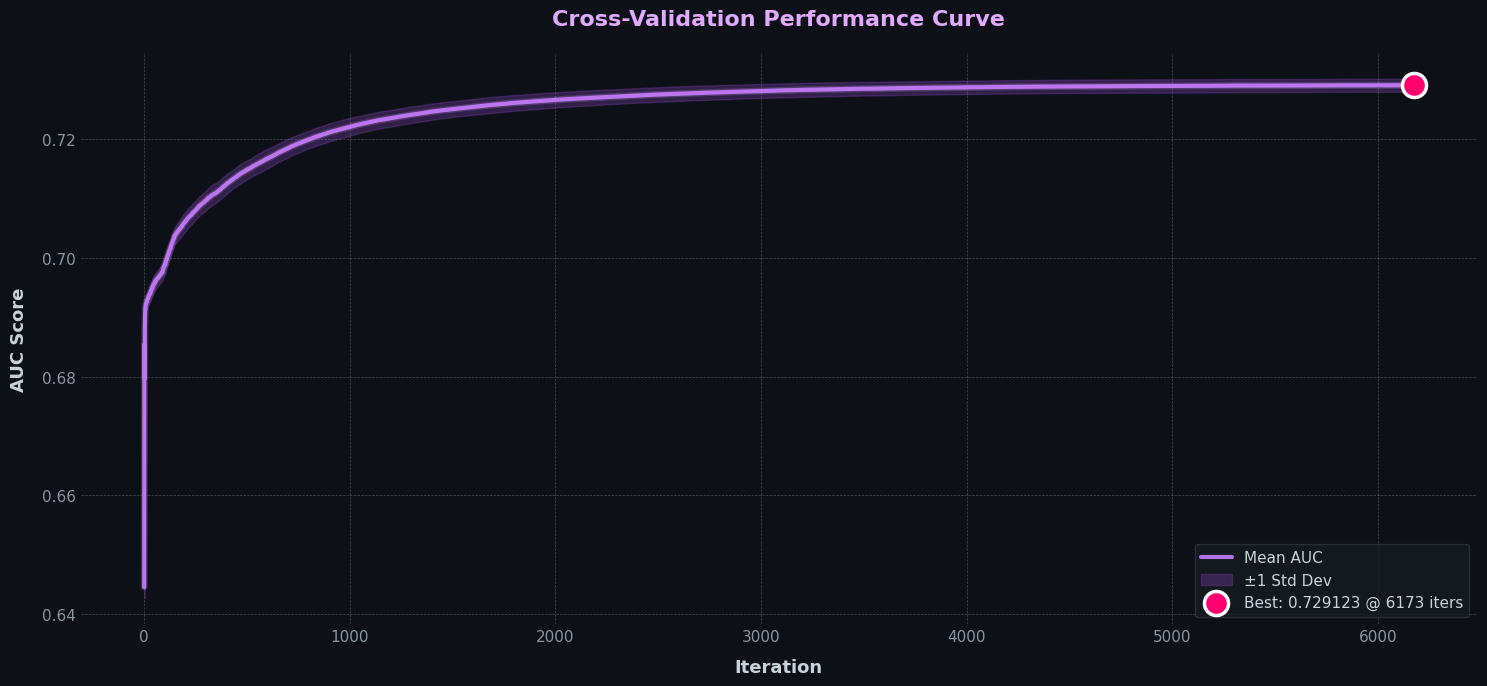

In [27]:
# Determine correct keys for CV results
auc_mean_key = [k for k in cv_results.keys() if 'auc-mean' in k][0]
auc_std_key  = [k for k in cv_results.keys() if 'auc-stdv' in k][0]

# Extract values
iterations = range(1, len(cv_results[auc_mean_key]) + 1)
mean_auc = cv_results[auc_mean_key]
std_auc  = cv_results[auc_std_key]

# Plot setup
fig, ax = plt.subplots(figsize=(15, 7), facecolor='#0d1117')

# Main line with glow effect
ax.plot(iterations, mean_auc, color='#c77dff', linewidth=3, label='Mean AUC', zorder=3, alpha=0.9)
ax.plot(iterations, mean_auc, color='#e0aaff', linewidth=5, alpha=0.2, zorder=2)

# Confidence band
ax.fill_between(
    iterations,
    np.array(mean_auc) - np.array(std_auc),
    np.array(mean_auc) + np.array(std_auc),
    alpha=0.25, color='#9d4edd', label='±1 Std Dev', zorder=1
)

# Best iteration marker
best_idx = np.argmax(mean_auc)
ax.scatter(
    iterations[best_idx], mean_auc[best_idx],
    color='#ff006e', s=300, zorder=4,
    edgecolors='#ffffff', linewidth=2.5,
    label=f'Best: {mean_auc[best_idx]:.6f} @ {iterations[best_idx]} iters'
)

# Labels & title
ax.set_xlabel('Iteration', fontsize=13, color='#c9d1d9', weight='600', labelpad=10)
ax.set_ylabel('AUC Score', fontsize=13, color='#c9d1d9', weight='600', labelpad=10)
ax.set_title('Cross-Validation Performance Curve', fontsize=16, color='#e0aaff', pad=20, weight='600')

# Legend & styling
ax.legend(loc='lower right', fontsize=11, frameon=True, facecolor='#161b22', edgecolor='#30363d')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#30363d')
ax.spines['bottom'].set_color('#30363d')
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [28]:
print("CV result keys:", cv_results.keys())

# --- Identify the correct key for mean AUC ---
auc_mean_key = None
for key in cv_results.keys():
    if 'auc' in key.lower() and 'mean' in key.lower():
        auc_mean_key = key
        break

if auc_mean_key is None:
    raise KeyError("No AUC mean key found in cv_results!")

# --- Compute optimal iterations ---
optimal_iterations = len(cv_results[auc_mean_key])
best_cv_score = cv_results[auc_mean_key][-1]

print(f"Optimal iterations from CV: {optimal_iterations}")
print(f"Best CV AUC: {best_cv_score:.7f}")

# --- Optionally, add buffer for final model ---
model_params['n_estimators'] = optimal_iterations + 100
print(f"Final model will use {model_params['n_estimators']} estimators")

CV result keys: dict_keys(['valid auc-mean', 'valid auc-stdv'])
Optimal iterations from CV: 6173
Best CV AUC: 0.7291230
Final model will use 6273 estimators


## Final model training and prediction

In [29]:
from lightgbm import LGBMClassifier

X_train = train_df.drop(columns=target_col)
y_train = train_df[target_col]
print("Training final model...")
final_model = LGBMClassifier(**model_params)
final_model.fit(X_train, y_train)

print("Final model training completed!")
print("Generating predictions...")
X_test = test_df.drop(columns=["id"])
test_predictions = final_model.predict_proba(X_test)[:, 1]
print("Predictions completed!")

Training final model...
Final model training completed!
Generating predictions...
Predictions completed!


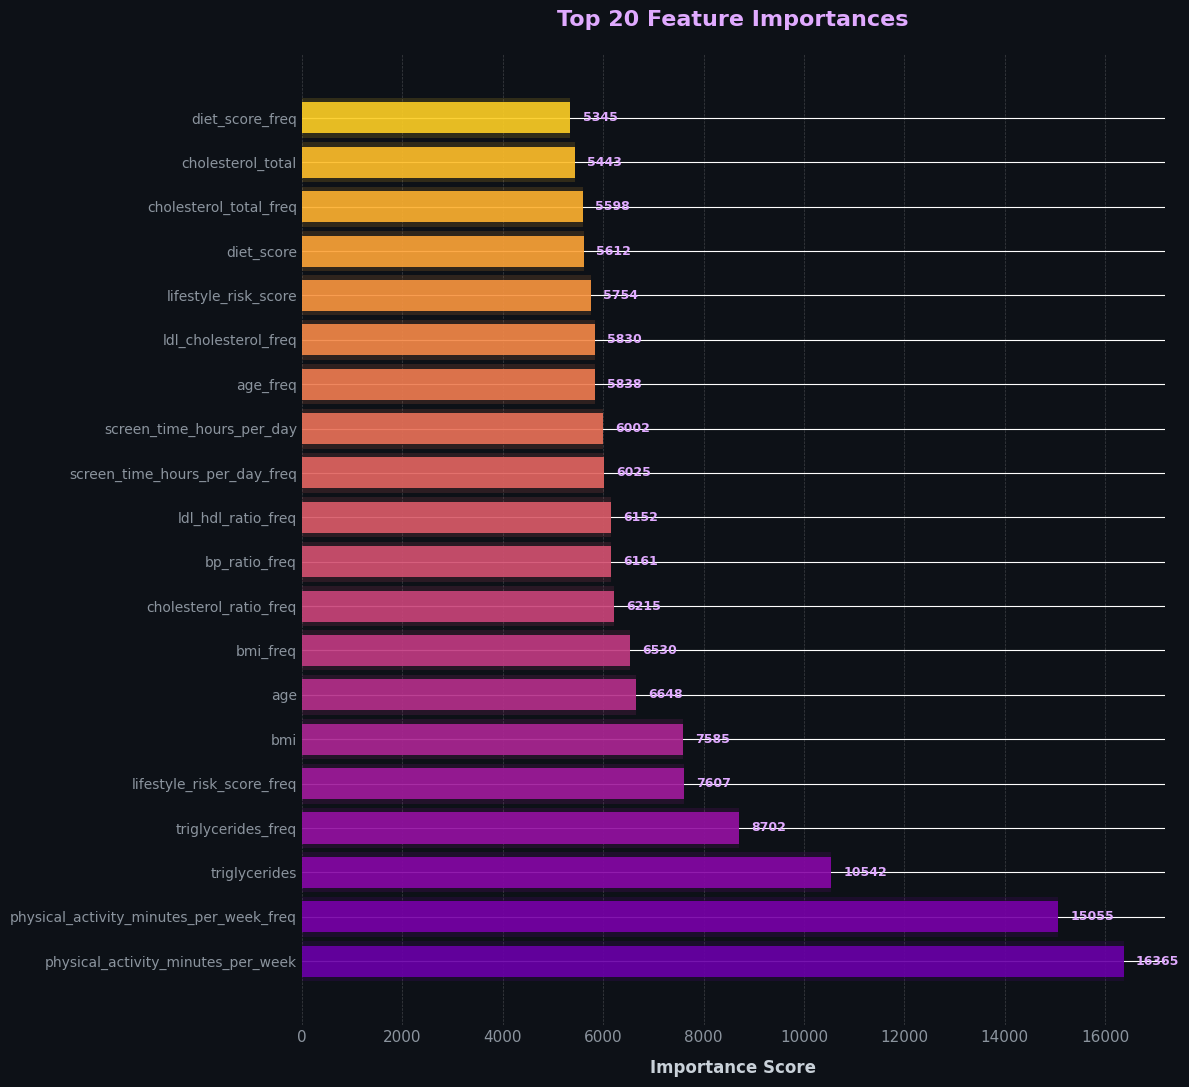


Top 20 Feature Importances:
                                feature  importance
     physical_activity_minutes_per_week       16365
physical_activity_minutes_per_week_freq       15055
                          triglycerides       10542
                     triglycerides_freq        8702
              lifestyle_risk_score_freq        7607
                                    bmi        7585
                                    age        6648
                               bmi_freq        6530
                 cholesterol_ratio_freq        6215
                          bp_ratio_freq        6161
                     ldl_hdl_ratio_freq        6152
         screen_time_hours_per_day_freq        6025
              screen_time_hours_per_day        6002
                               age_freq        5838
                   ldl_cholesterol_freq        5830
                   lifestyle_risk_score        5754
                             diet_score        5612
                 cholesterol_total_

In [30]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(12, 11), facecolor='#0d1117')

colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(feature_importance)))
y_pos = np.arange(len(feature_importance))

# Horizontal bars
bars = ax.barh(y_pos, feature_importance['importance'], height=0.7,
               color=colors, edgecolor='none', alpha=0.9)

# Glow effect
for i, bar in enumerate(bars):
    ax.barh(y_pos[i], feature_importance.iloc[i]['importance'], 
            height=0.9, color=colors[i], alpha=0.15, edgecolor='none')

# Labels & styling
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance['feature'], fontsize=10)
ax.set_xlabel('Importance Score', fontsize=12, color='#c9d1d9', weight='600', labelpad=10)
ax.set_title('Top 20 Feature Importances', fontsize=16, color='#e0aaff', pad=20, weight='600')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#30363d')
ax.spines['bottom'].set_color('#30363d')
ax.grid(True, alpha=0.2, axis='x', linestyle='--', linewidth=0.5)

# Value labels
for i, val in enumerate(feature_importance['importance']):
    ax.text(val + max(feature_importance['importance'])*0.015, i, f'{val:.0f}', 
            va='center', color='#e0aaff', fontsize=9, weight='600')

plt.tight_layout()
plt.show()

# Display table
print("\nTop 20 Feature Importances:")
print(feature_importance.to_string(index=False))

## Prediction distribution  analysis

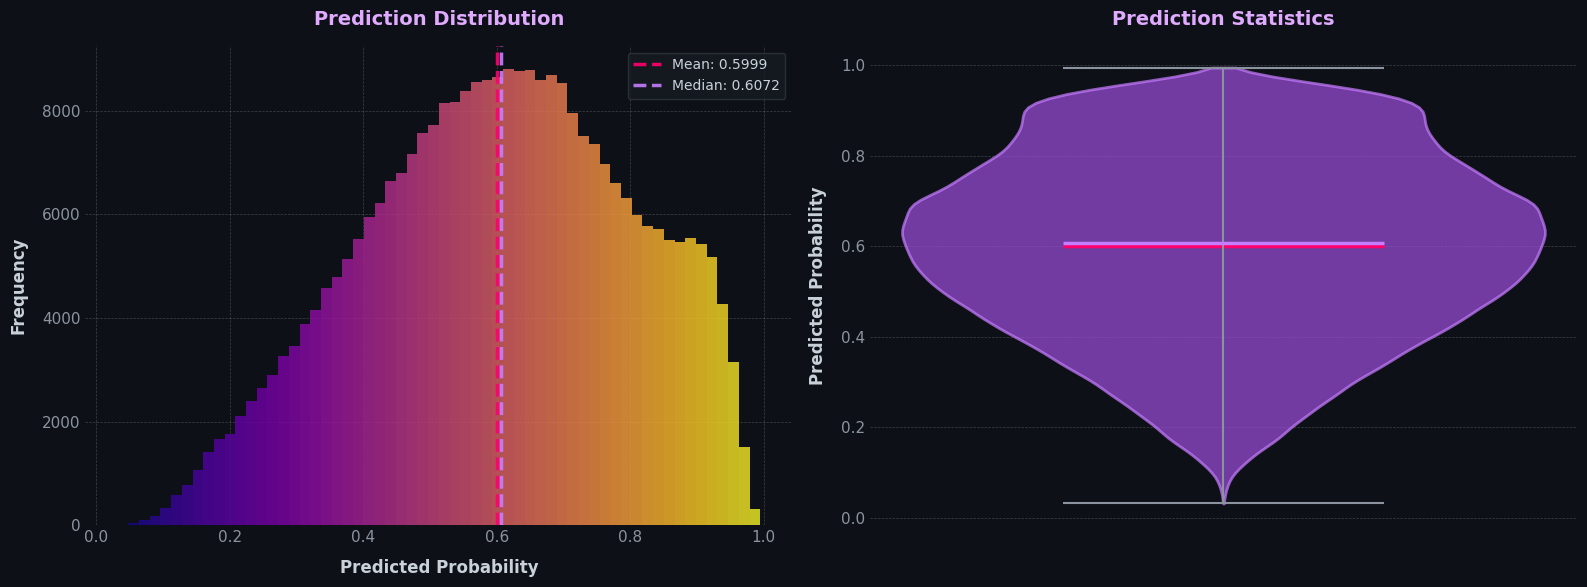


Prediction Statistics:
Mean:   0.599854
Median: 0.607208
Std:    0.198414
Min:    0.031898
Max:    0.994984


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor='#0d1117')
fig.subplots_adjust(wspace=0.3)
ax1 = axes[0]
n, bins, patches = ax1.hist(test_predictions, bins=60, color='#9d4edd', 
                             edgecolor='none', alpha=0.8)
for i, patch in enumerate(patches):
    patch.set_facecolor(plt.cm.plasma(i / len(patches)))

# Mean & median lines
ax1.axvline(test_predictions.mean(), color='#ff006e', linestyle='--', 
            linewidth=2.5, label=f'Mean: {test_predictions.mean():.4f}', alpha=0.9)
ax1.axvline(np.median(test_predictions), color='#c77dff', linestyle='--', 
            linewidth=2.5, label=f'Median: {np.median(test_predictions):.4f}', alpha=0.9)

ax1.set_xlabel('Predicted Probability', fontsize=12, color='#c9d1d9', weight='600', labelpad=10)
ax1.set_ylabel('Frequency', fontsize=12, color='#c9d1d9', weight='600', labelpad=10)
ax1.set_title('Prediction Distribution', fontsize=14, color='#e0aaff', pad=15, weight='600')
ax1.legend(loc='upper right', frameon=True, facecolor='#161b22', edgecolor='#30363d', fontsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#30363d')
ax1.spines['bottom'].set_color('#30363d')
ax1.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax2 = axes[1]
parts = ax2.violinplot([test_predictions], positions=[0], widths=0.7,
                        showmeans=True, showmedians=True, showextrema=True)

# Styling the violin
for pc in parts['bodies']:
    pc.set_facecolor('#9d4edd')
    pc.set_edgecolor('#c77dff')
    pc.set_alpha(0.7)
    pc.set_linewidth(2)

parts['cmeans'].set_edgecolor('#ff006e')
parts['cmeans'].set_linewidth(2.5)
parts['cmedians'].set_edgecolor('#c77dff')
parts['cmedians'].set_linewidth(2.5)
parts['cbars'].set_edgecolor('#8b949e')
parts['cmaxes'].set_edgecolor('#8b949e')
parts['cmins'].set_edgecolor('#8b949e')

ax2.set_ylabel('Predicted Probability', fontsize=12, color='#c9d1d9', weight='600', labelpad=10)
ax2.set_title('Prediction Statistics', fontsize=14, color='#e0aaff', pad=15, weight='600')
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#30363d')
ax2.spines['bottom'].set_visible(False)
ax2.grid(True, alpha=0.2, axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("\nPrediction Statistics:")
print(f"Mean:   {test_predictions.mean():.6f}")
print(f"Median: {np.median(test_predictions):.6f}")
print(f"Std:    {test_predictions.std():.6f}")
print(f"Min:    {test_predictions.min():.6f}")
print(f"Max:    {test_predictions.max():.6f}")

In [32]:
submission = pd.DataFrame({
    "id": test_df["id"],
    target_col: test_predictions
})

submission_file = "submission.csv"
submission.to_csv(submission_file, index=False)
print("✓ Submission file created successfully!")
print(f"✓ Total predictions: {len(submission)}")
print("\nSubmission preview:")
print(submission.head(10))

✓ Submission file created successfully!
✓ Total predictions: 300000

Submission preview:
       id  diagnosed_diabetes
0  700000            0.475247
1  700001            0.679952
2  700002            0.777608
3  700003            0.378524
4  700004            0.936110
5  700005            0.671616
6  700006            0.740553
7  700007            0.934600
8  700008            0.573336
9  700009            0.842540


## Thank you..pls upvote!!!!